# Chapter 5 - Nonlinear Interactions (Python Code)

We begin with some imports

In [1]:
import quantecon as qe
import quantecon_book_networks.input_output as qbn_io
import quantecon_book_networks.plotting as qbn_plt
import quantecon_book_networks.data as qbn_data

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

## Financial Networks

### Equity-Cross Holdings

Here we define a class for modelling a financial network where firms are linked by share cross-holdings, and there are failure costs as described by [Elliott et al. (2014)](https://www.aeaweb.org/articles?id=10.1257/aer.104.10.3115).

In [3]:
class FinNet:
    
    def __init__(self, n=100, c=0.72, d=1, θ=0.5, β=1.0, seed=1234):
        
        self.n, self.c, self.d, self.θ, self.β = n, c, d, θ, β
        np.random.seed(seed)
        
        self.e = np.ones(n)
        self.C, self.C_hat = self.generate_primitives()
        self.A = self.C_hat @ np.linalg.inv(np.identity(n) - self.C)
        self.v_bar = self.A @ self.e
        self.t = np.full(n, θ)
        
    def generate_primitives(self):
        
        n, c, d = self.n, self.c, self.d
        B = np.zeros((n, n))
        C = np.zeros_like(B)

        for i in range(n):
            for j in range(n):
                if i != j and np.random.rand() < d/(n-1):
                    B[i,j] = 1
                
        for i in range(n):
            for j in range(n):
                k = np.sum(B[:,j])
                if k > 0:
                    C[i,j] = c * B[i,j] / k
                
        C_hat = np.identity(n) * (1 - c)
    
        return C, C_hat
        
    def T(self, v):
        Tv = self.A @ (self.e - self.β * np.where(v < self.t, 1, 0))
        return Tv
    
    def compute_equilibrium(self):
        i = 0
        v = self.v_bar
        error = 1
        while error > 1e-10:
            print(f"number of failing firms is ", np.sum(v < self.θ))
            new_v = self.T(v)
            error = np.max(np.abs(new_v - v))
            v = new_v
            i = i+1
            
        print(f"Terminated after {i} iterations")
        return v
    
    def map_values_to_colors(self, v, j):
        cols = cm.plasma(qbn_io.to_zero_one(v))
        if j != 0:
            for i in range(len(v)):
                if v[i] < self.t[i]:
                    cols[i] = 0.0
        return cols

Now we create a financial network.

In [4]:
fn = FinNet(n=100, c=0.72, d=1, θ=0.3, β=1.0)

And compute its equilibirum.

In [5]:
fn.compute_equilibrium()

number of failing firms is  31
number of failing firms is  42
number of failing firms is  49
number of failing firms is  52
number of failing firms is  55
number of failing firms is  57
number of failing firms is  59
number of failing firms is  62
number of failing firms is  64
number of failing firms is  66
number of failing firms is  69
number of failing firms is  77
number of failing firms is  81
number of failing firms is  86
number of failing firms is  93
number of failing firms is  97
number of failing firms is  99
number of failing firms is  100
number of failing firms is  100
Terminated after 19 iterations


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Waves of bankruptcies in a financial network

Now we will visualise the network after different numbers of iterations. For convenience we will first define a function to plot the graphs of the finiancial network.

In [6]:
def plot_fin_graph(G, ax, node_color_list):
    
    n = G.number_of_nodes()

    node_pos_dict = nx.spring_layout(G, k=1.1)
    edge_colors = []

    for i in range(n):
        for j in range(n):
            edge_colors.append(node_color_list[i])

    
    nx.draw_networkx_nodes(G, 
                           node_pos_dict, 
                           node_color=node_color_list, 
                           edgecolors='grey', 
                           node_size=100,
                           linewidths=2, 
                           alpha=0.8, 
                           ax=ax)

    nx.draw_networkx_edges(G, 
                           node_pos_dict, 
                           edge_color=edge_colors, 
                           alpha=0.4,  
                           ax=ax)

Now we will iterate by applying the operator $T$ to the vector of firm values $v$ and produce the plots.

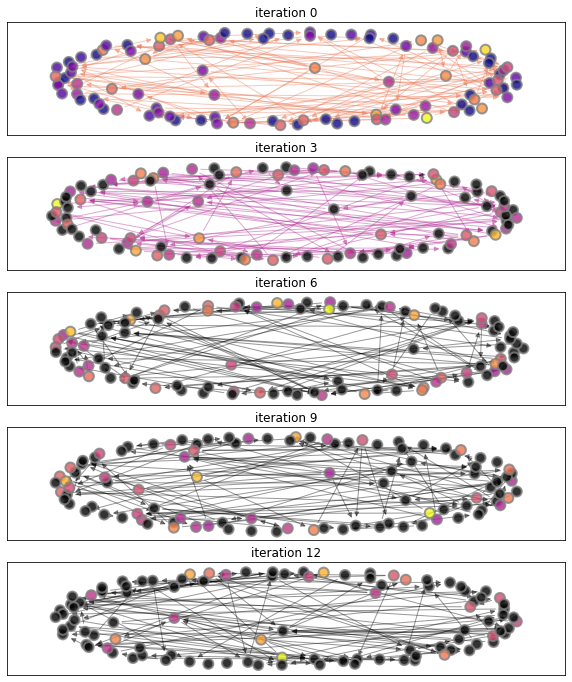

In [7]:
G = nx.from_numpy_matrix(np.matrix(fn.C), create_using=nx.DiGraph)
v = fn.v_bar

k = 15
d = 3
fig, axes = plt.subplots(int(k/d), 1, figsize=(10, 12))

for i in range(k):
    if i % d == 0:
        ax = axes[int(i/d)]
        ax.set_title(f"iteration {i}")

        plot_fin_graph(G, ax, fn.map_values_to_colors(v, i))
    v = fn.T(v)
plt.show()
